In [1]:
# Add root directory to path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.abspath('..'),
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)

# Imports
from electronTransportCode.SimOptions import PointSource
from electronTransportCode.SimulationDomain import SimulationDomain
from electronTransportCode.MCParticleTracer import AnalogParticleTracer
from electronTransportCode.MCEstimator import FluenceEstimator, DoseEstimator, TrackEndEstimator
from electronTransportCode.ParticleModel import PointSourceParticle
from electronTransportCode.Material import unitDensityMaterial
%matplotlib widget

### Set up all objects
Either do simulation, or load objects from data file

In [2]:
SEED: int = 4  # Random number generator seed
SIM: bool = True

if SIM:
    NB_PARTICLES = 30000
    
    # Set up initial conditions
    eSource: float = 1.0

    # Set up simulation domain
    xmin = -1.0; xmax = 1.0; xbins = 100
    ymin = -1.0; ymax = 1.0; ybins = 100
    simDomain = SimulationDomain(xmin, xmax, ymin, ymax, xbins, ybins, material=unitDensityMaterial)
    pointSourceSim = PointSource(minEnergy=0.0, rngSeed=SEED, eSource=eSource)

    # Set up dose estimator
    Ebins = 100
    fluenceEstimator = FluenceEstimator(simDomain=simDomain, Emin=0.0, Emax=eSource, Ebins=Ebins)
    doseEstimator = DoseEstimator(simDomain)
    trackEndEstimatorx = TrackEndEstimator(simDomain, NB_PARTICLES, setting='x')
    trackEndEstimatorrz = TrackEndEstimator(simDomain, NB_PARTICLES, setting='rz')
    trackEndEstimatorr = TrackEndEstimator(simDomain, NB_PARTICLES, setting='r')

    # Set up particle
    particle = PointSourceParticle(generator=SEED)  # rng is later overridden by simulation object 

    # Set up particle tracer
    particleTracer = AnalogParticleTracer(particle=particle, simOptions=pointSourceSim, simDomain=simDomain)
    
    particleTracer(nbParticles=NB_PARTICLES, estimators=(fluenceEstimator, doseEstimator, trackEndEstimatorx, trackEndEstimatorrz, trackEndEstimatorr))
    print(f'Average amount of events: {particleTracer.averageNbCollisions}')
else:
    with open('data/particleTracer.pkl', 'rb') as file:
        particleTracer = pickle.load(file)
        
    with open('data/fluenceEstimator.pkl', 'rb') as file:
        fluenceEstimator = pickle.load(file)
        
    with open('data/doseEstimator.pkl', 'rb') as file:
        doseEstimator = pickle.load(file)
        
    with open('data/trackEndEstimatorx.pkl', 'rb') as file:
        trackEndEstimatorx = pickle.load(file)

    with open('data/trackEndEstimatorrz.pkl', 'rb') as file:
        trackEndEstimatorrz = pickle.load(file)

    with open('data/trackEndEstimatorr.pkl', 'rb') as file:
        trackEndEstimatorr = pickle.load(file)

    particle = particleTracer.particle
    simDomain = particleTracer.simDomain
    pointSourceSim = particleTracer.simOptions

    eSource= pointSourceSim.eSource
    xmin = simDomain.xmin
    xmax = simDomain.xmax
    ymin = simDomain.ymin
    ymax = simDomain.ymax
    xbins = simDomain.xbins
    ybins = simDomain.ybins
    Ebins = fluenceEstimator.Ebins

Last 1000 particles took 6.160439590999886 seconds. 3.3333333333333335% completed.
Last 1000 particles took 3.370158335001179 seconds. 6.666666666666667% completed.
Last 1000 particles took 3.7615630039999814 seconds. 10.0% completed.
Last 1000 particles took 3.1771271730012813 seconds. 13.333333333333334% completed.
Last 1000 particles took 3.2702356839999993 seconds. 16.666666666666668% completed.
Last 1000 particles took 3.4107681389996287 seconds. 20.0% completed.
Last 1000 particles took 3.338436677999198 seconds. 23.333333333333332% completed.
Last 1000 particles took 3.0380528229998163 seconds. 26.666666666666668% completed.
Last 1000 particles took 2.586992325999745 seconds. 30.0% completed.
Last 1000 particles took 2.552659152999695 seconds. 33.333333333333336% completed.
Last 1000 particles took 2.9619561119998252 seconds. 36.666666666666664% completed.
Last 1000 particles took 3.7422797629988054 seconds. 40.0% completed.
Last 1000 particles took 3.461121053998795 seconds. 43

In [3]:
# Sanity check
print(doseEstimator.scoreMatrix.sum())  # Total energy and total simulation time. Should be equal to the amount of particles.
print(fluenceEstimator.scoreMatrix.sum())

29999.999999999996
30000.0


Plot 2D particle distribution

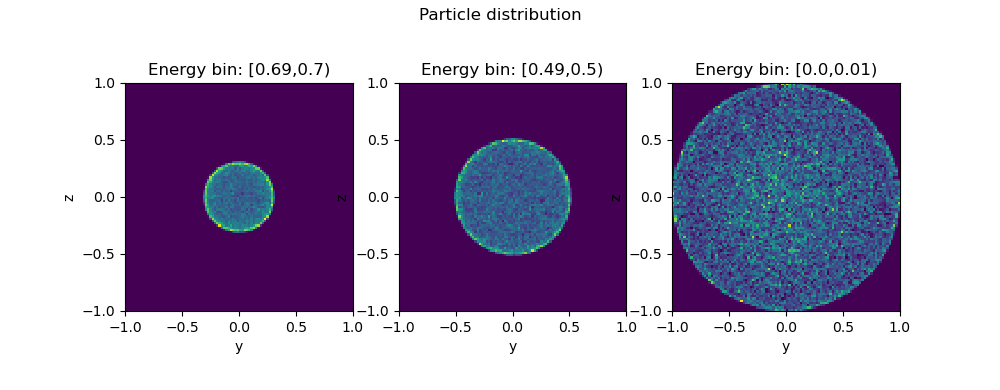

In [4]:
# Plot energy deposition
ebin2Index = 0
ebin1Index = int((Ebins-1)/2)
ebin3Index = int(7*(Ebins-1)/10)
Fluence3 = np.flipud(np.reshape(fluenceEstimator.scoreMatrix[ebin3Index, :], (ybins, xbins)))
Fluence2 = np.flipud(np.reshape(fluenceEstimator.scoreMatrix[ebin2Index, :], (ybins, xbins)))
Fluence1 = np.flipud(np.reshape(fluenceEstimator.scoreMatrix[ebin1Index, :], (ybins, xbins)))

fig, (ax3, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3.9))
fig.suptitle('Particle distribution')

roundDigits = 3

bin1left = np.round(fluenceEstimator.Erange[ebin1Index], roundDigits)
bin1right = np.round(fluenceEstimator.Erange[ebin1Index+1], roundDigits)
ax1.set_title(f'Energy bin: [{bin1left},{bin1right})')
ax1.matshow(Fluence1, extent=[xmin, xmax, ymin, ymax])
ax1.set_xticks(np.linspace(xmin, xmax, 5))
ax1.set_yticks(np.linspace(xmin, xmax, 5))
ax1.xaxis.tick_bottom()
ax1.set_xlabel('y')
ax1.set_ylabel('z')

# End particle distribution
bin2left = np.round(fluenceEstimator.Erange[ebin2Index], roundDigits)
bin2right = np.round(fluenceEstimator.Erange[ebin2Index+1], roundDigits)
ax2.matshow(Fluence2, extent=[xmin, xmax, ymin, ymax])
ax2.set_title(f'Energy bin: [{bin2left},{bin2right})')
ax2.set_xticks(np.linspace(xmin, xmax, 5))
ax2.set_yticks(np.linspace(xmin, xmax, 5))
ax2.xaxis.tick_bottom()
ax2.set_xlabel('y')
ax2.set_ylabel('z')

bin3left = np.round(fluenceEstimator.Erange[ebin3Index], roundDigits)
bin3right = np.round(fluenceEstimator.Erange[ebin3Index+1], roundDigits)
ax3.set_title(f'Energy bin: [{bin3left},{bin3right})')
ax3.matshow(Fluence3, extent=[xmin, xmax, ymin, ymax])
ax3.set_xticks(np.linspace(xmin, xmax, 5))
ax3.set_yticks(np.linspace(xmin, xmax, 5))
ax3.xaxis.tick_bottom()
ax3.set_xlabel('y')
ax3.set_ylabel('z')


plt.show()

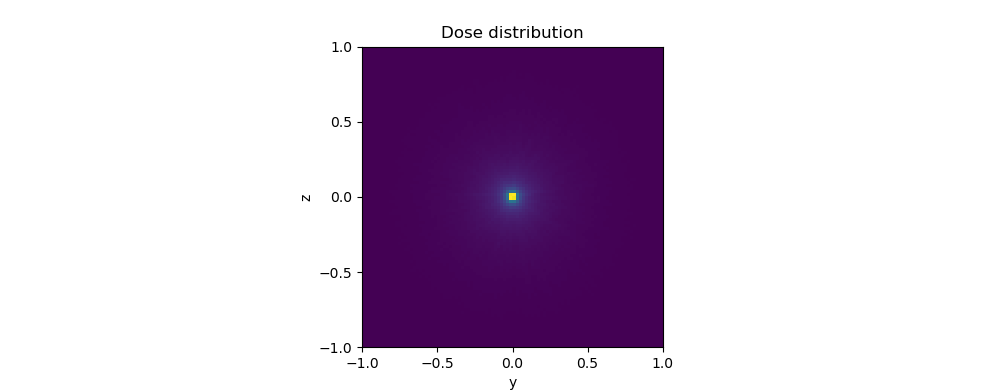

In [5]:
# Dose distribution. Simulate a low number of tracks to see the paths.
dose = np.flipud(np.reshape(doseEstimator.scoreMatrix, (ybins, xbins)))

fig, ax1 = plt.subplots(figsize=(10, 3.9))
ax1.matshow(dose, extent=[xmin, xmax, ymin, ymax])
ax1.set_title(f'Dose distribution')
ax1.set_xticks(np.linspace(xmin, xmax, 5))
ax1.set_yticks(np.linspace(xmin, xmax, 5))
ax1.xaxis.tick_bottom()
ax1.set_xlabel('y')
ax1.set_ylabel('z')

plt.show()

In [6]:
# # Compute exact solution at E = 0 (t = 1)
import exactSolution

solRes = 501
rsTemp = np.linspace(-1.0, 1.0, solRes)  # Discontuity from the source at the origin
ys = np.zeros((solRes-1, ))

for index in range(solRes-1):
    ys[index] = (rsTemp[index]+rsTemp[index+1])/2

resy = np.zeros_like(ys)
for index, r in enumerate(ys):
    resy[index] = exactSolution.planeSourceSolution(r, 0.0, eSource)

# Normalize
resy = resy/np.trapz(resy, ys)  

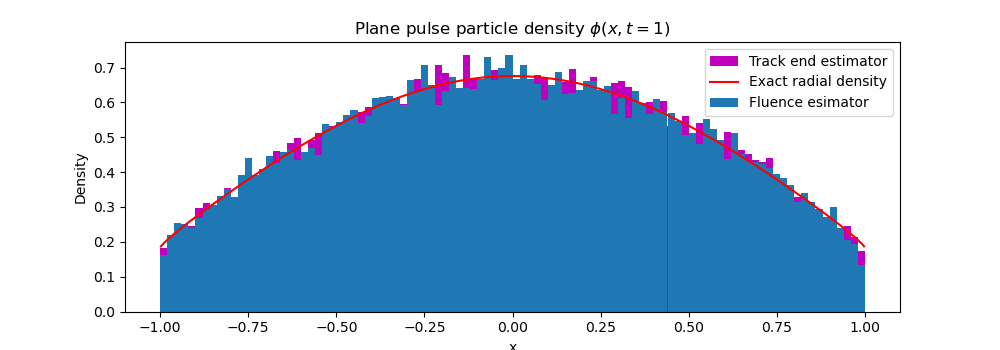

In [7]:
fig, ax1 = plt.subplots(figsize=(10, 3.5))
xdensity = trackEndEstimatorx.scoreMatrix
binVal, binEdge, _ = ax1.hist(xdensity, bins=100, density=True, color='m', label='Track end estimator')

xs = np.linspace(xmin, xmax, xbins+1)
dx = xs[1] - xs[0]
ax1.bar(x=xs[:-1], height=Fluence2.sum(axis=1)/(dx*Fluence2.sum()), width = dx, label='Fluence esimator', align='edge')

ax1.set_xlabel('x')
ax1.set_ylabel('Density')
ax1.set_title('Plane pulse particle density $\phi(x, t=1)$')
ax1.plot(ys, resy, color='r', label='Exact radial density')
ax1.legend()

The simulation corresponds to the exact solution. The y and z distributions are exactly the same!

0.6088999999999998
0.39110000000000034


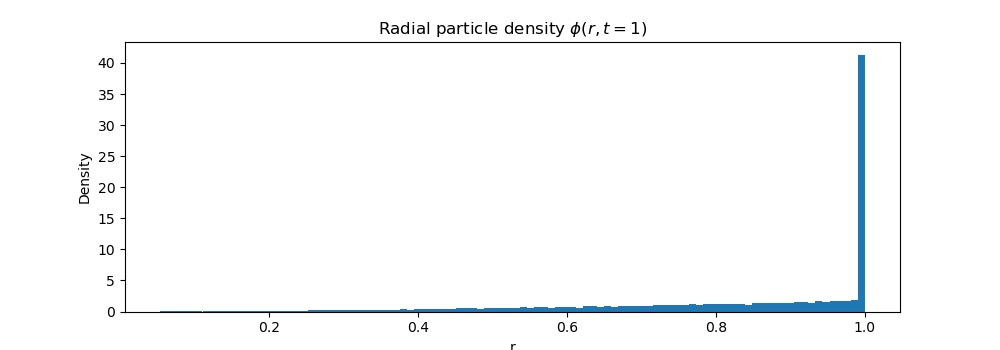

In [8]:
fig, ax1 = plt.subplots(figsize=(10, 3.5))
radialDensity = trackEndEstimatorr.scoreMatrix
binVal, binEdge, _ = ax1.hist(radialDensity, bins=100, density=True)
ax1.set_xlabel('r')
ax1.set_ylabel('Density')
ax1.set_title('Radial particle density $\phi(r, t=1)$')

print(sum(binVal[0:-1])/sum(binVal))  # Theoretical 
print(binVal[-1]/sum(binVal)) 

The scattering rate is 1, particles move at velocity 1 and they are transported for 1 second. From the exponential distribution we thus know that 63.2% of particles will collide within 1 distance unit. The other 36.8 percent of particles will not collide and are thus expected to be at the edge of the domain after 1 second. Particles that have collided scatter with an average angle of 90 degrees and thus cannot reach the border before t = 1.

From the simulation we have that 61% of particles, at time = 1, lie in the domain [0, 0.99]. The remaining 39% lie in the final bin. This is intuitively correct.

Text(0.5, 1.0, 'Radial particle density (rz)')

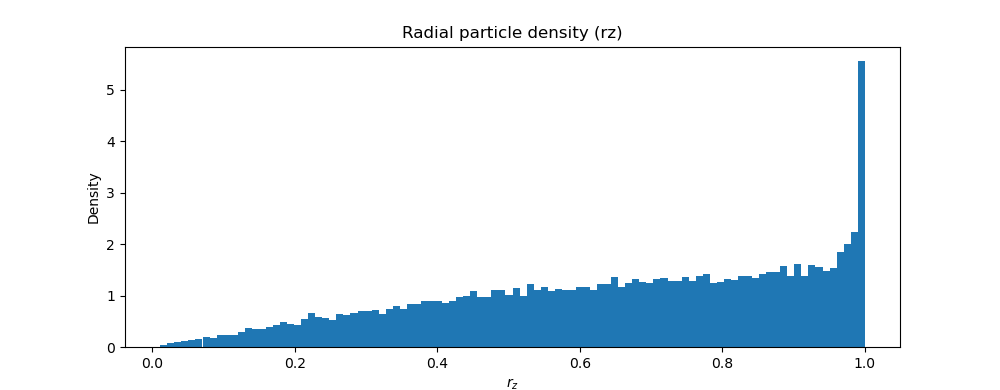

In [9]:
fig, ax1 = plt.subplots(figsize=(10, 3.9))
radialzDensity = trackEndEstimatorrz.scoreMatrix
binVal, binEdge, _ = ax1.hist(radialzDensity, bins=100, density=True)
ax1.set_xlabel('$r_z$')
ax1.set_ylabel('Density')
ax1.set_title('Radial particle density (rz)')

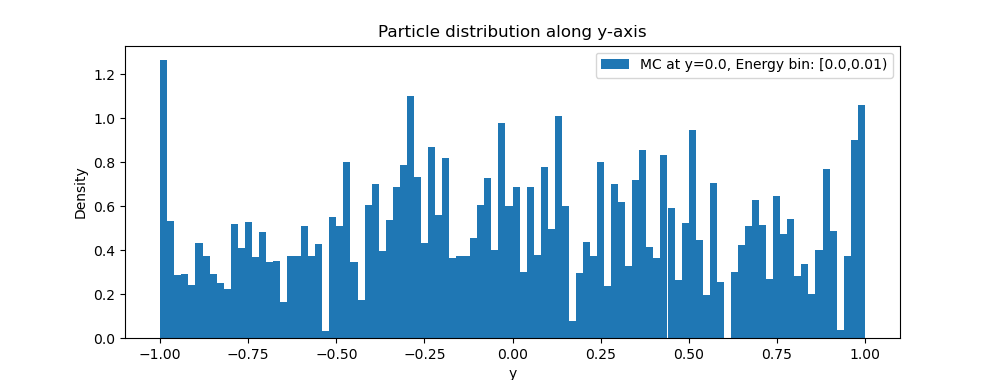

In [10]:
 # End particle distribution along y-axis
zbin1Index = int((ybins)/2)

zbin1down = np.round(simDomain.yrange[zbin1Index], roundDigits)
zbin1up = np.round(simDomain.yrange[zbin1Index+1], roundDigits)

finalFluencez = Fluence2[zbin1Index, : ]  # finalFluence.sum(axis=0)  
fig, ax1 = plt.subplots(figsize=(10, 3.8))
ax1.set_title('Particle distribution along y-axis')

dxMC = simDomain.xrange[1]-simDomain.xrange[0]
normMC = (finalFluencez.sum()*dxMC)

ax1.bar(simDomain.xrange[:-1], finalFluencez/normMC, align='edge', width=dxMC, 
        label=f'MC at y={np.round(simDomain.xrange[zbin1Index], roundDigits)}, Energy bin: [{bin2left},{bin2right})')
ax1.set_xlabel('y')
ax1.set_ylabel('Density')
ax1.legend() 

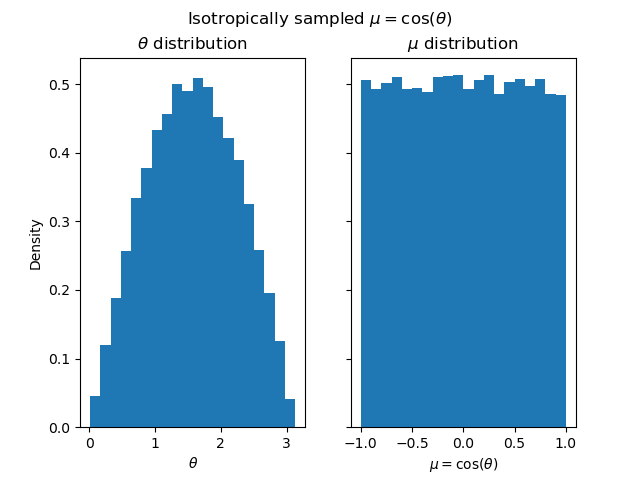

In [11]:
Nbsamples = 50000

mu2 = np.random.uniform(low=-1, high=1, size = Nbsamples)
theta = np.arccos(mu2)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle(r'Isotropically sampled $\mu = \cos(\theta)$')

ax1.hist(theta, bins = 20, density=True)
ax1.set_xlabel(r'$\theta$')
ax1.set_ylabel('Density')
ax1.set_title(r'$\theta$ distribution')

ax2.hist(mu2, bins = 20, density=True)
ax2.set_xlabel(r'$\mu = \cos(\theta)$')
ax2.set_title(r'$\mu$ distribution')

plt.show()